In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [8]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # 9 files
K = 6 # 6 Classes


def load_data():
    # returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    
    
    ##### train data
    ts_filenames = [
        'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
        'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
        'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt'
    ]
    
    ts_file_prefix = '../Data/UCI HAR Dataset/train/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntrain x T array
        x = df.to_numpy()
        Xtrain[:, :, d] = x
        
    
    # train labels
    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt',
            header = None).to_numpy() -1
    Ytrain = Ytrain.flatten()
    
    
    
    ##### test data
    ts_filenames = [
        'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
        'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
        'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt'
    ]
    ts_file_prefix = '../Data/UCI HAR Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntest x T array
        x = df.to_numpy()
        Xtest[:, :, d] = x
        
    # test labels
    Ytest = pd.read_csv(
        f'{ts_file_prefix}y_test.txt',
            header = None).to_numpy() -1
    Ytest = Ytest.flatten()
    
    
    return Xtrain, Ytrain, Xtest, Ytest

# Load Data

In [9]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

In [17]:
# CNN
i = Input(shape = (T, D))
x = Conv1D(32, 5, activation = 'relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [18]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 32)           1472      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 41, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0   

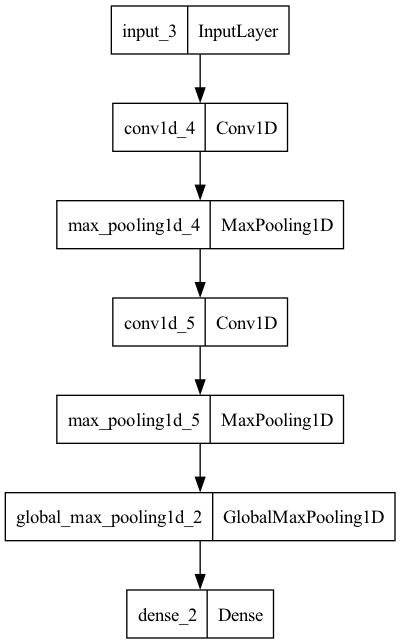

In [19]:
tf.keras.utils.plot_model(model)

In [24]:
# To save the best model
check_point = ModelCheckpoint(
    'best_model.h5', monitor = 'val_accuracy', save_best_only = True)


model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy'],
)

r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 15,
    callbacks = [check_point],
    validation_data = (Xtest, Ytest)
)

Epoch 1/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0654 - accuracy: 0.9708 - val_loss: 0.2354 - val_accuracy: 0.9226
Epoch 2/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0644 - accuracy: 0.9735 - val_loss: 0.2655 - val_accuracy: 0.9186
Epoch 3/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0621 - accuracy: 0.9732 - val_loss: 0.2430 - val_accuracy: 0.9199
Epoch 4/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0620 - accuracy: 0.9748 - val_loss: 0.2536 - val_accuracy: 0.9148
Epoch 5/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0567 - accuracy: 0.9759 - val_loss: 0.2429 - val_accuracy: 0.9203
Epoch 6/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0535 - accuracy: 0.9792 - val_loss: 0.2684 - val_accuracy: 0.9104
Epoch 7/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0523 - accuracy: 0.9785 - val_loss: 0.2590 - val_accuracy: 0.9203
Epoch 

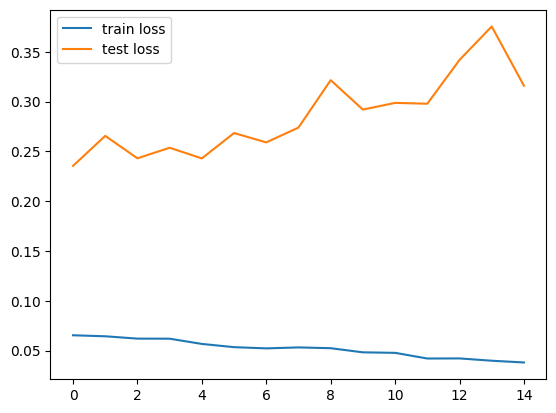

In [25]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

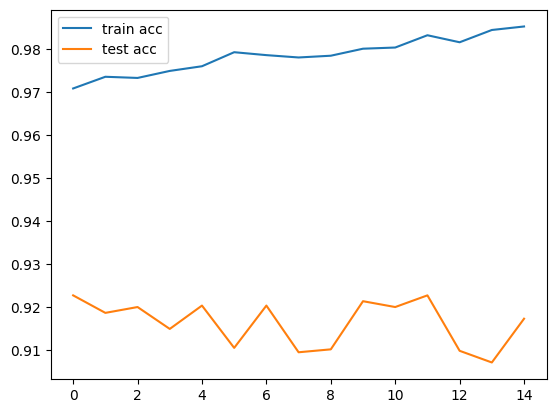

In [26]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'test acc')
plt.legend();

In [27]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# make predictions
Ptest = best_model.predict(Xtest)

# evauluate
np.mean(np.argmax(Ptest, axis = 1) == Ytest)

93/93 [==============================] - 0s 2ms/step


0.9226331862911435

# 1 step forecast

<Axes: xlabel='Month'>

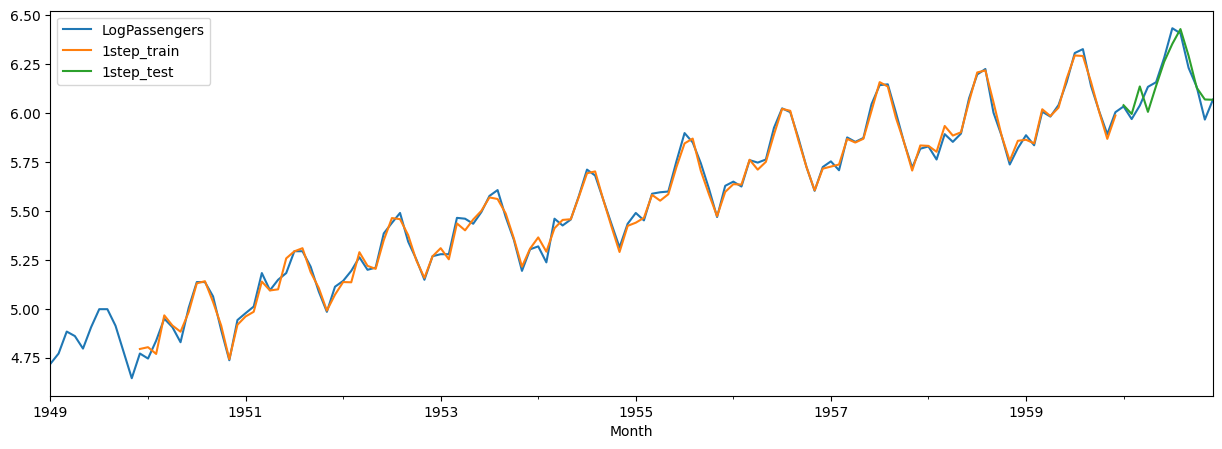

In [29]:
# undifference
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# Last-Known train vlaue
last_train = train.iloc[-1]['LogPassengers']

# 1-step forecast
df.loc[train_idx, "1step_train"] = prev[train_idx] + Ptrain
df.loc[test_idx, "1step_test"] = prev[test_idx] + Ptest

# Plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize = (15, 5))

# Multistep forecast

1/1 [==============================] - 0s 11ms/step


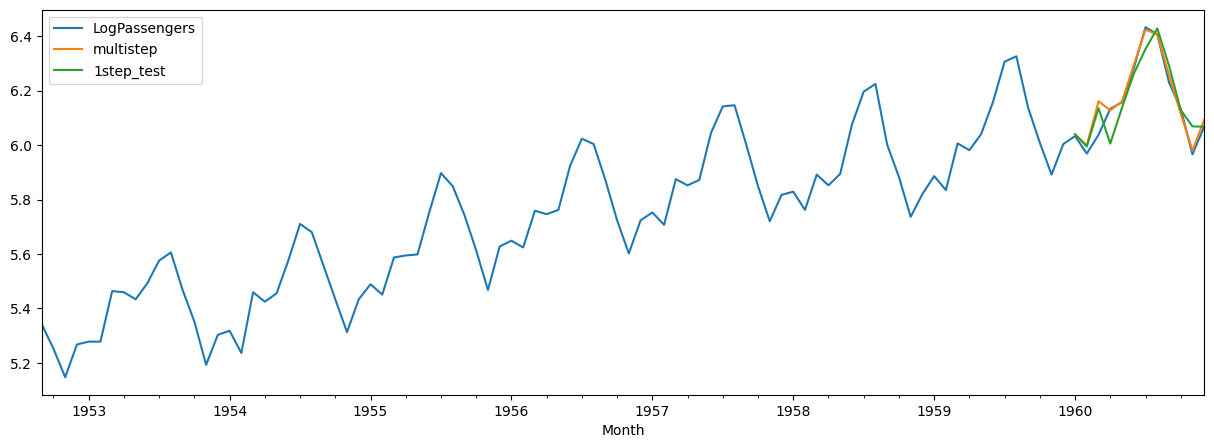

In [32]:
# Multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
    
    multistep_predictions.append(p)
    
    last_x = np.roll(last_x,-1) # [1,2,3] -> [2,3,1]
    last_x[-1] = p # Replace the last value with the predicted value

# Save prediction
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

# plot 1-step, multistep forecast
df.iloc[-100:][['LogPassengers', 'multistep', '1step_test']].plot(figsize = (15, 5));

# multi output forcast

In [33]:
# Create AR like data
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t: t+Tx]
    X.append(x)
    
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    

# Reshape Data
X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print('X.shape', X.shape, 'Y.shpae', Y.shape)

X.shape (122, 10, 1) Y.shpae (122, 12)


Epoch 1/200
4/4 [==============================] - 0s 86ms/step - loss: 0.0125 - val_loss: 0.0141
Epoch 2/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0117 - val_loss: 0.0129
Epoch 3/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0122
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 7/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 8/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 9/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/200
4/4 [==============================] - 0s 42ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 11/200
4/4 [=

Epoch 84/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 85/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 86/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 87/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 88/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 89/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 90/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 91/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 92/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 93/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 94/2

4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 167/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 168/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 169/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 170/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 171/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 172/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 173/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 174/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 175/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 176/200


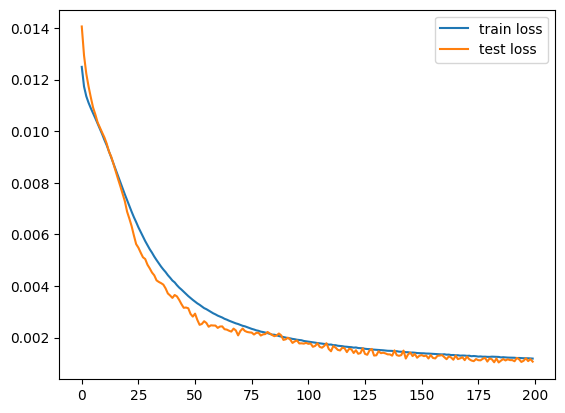

In [35]:
# Split train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

# CNN
i = Input(shape = (Tx, 1))
x = Conv1D(16, 3, activation = 'relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

model.compile(
    loss = 'mse',
    optimizer = 'adam',
)

r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs = 200,
    validation_data = (Xtest_m, Ytest_m)
)

plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

1/1 [==============================] - 0s 24ms/step


<Axes: xlabel='Month'>

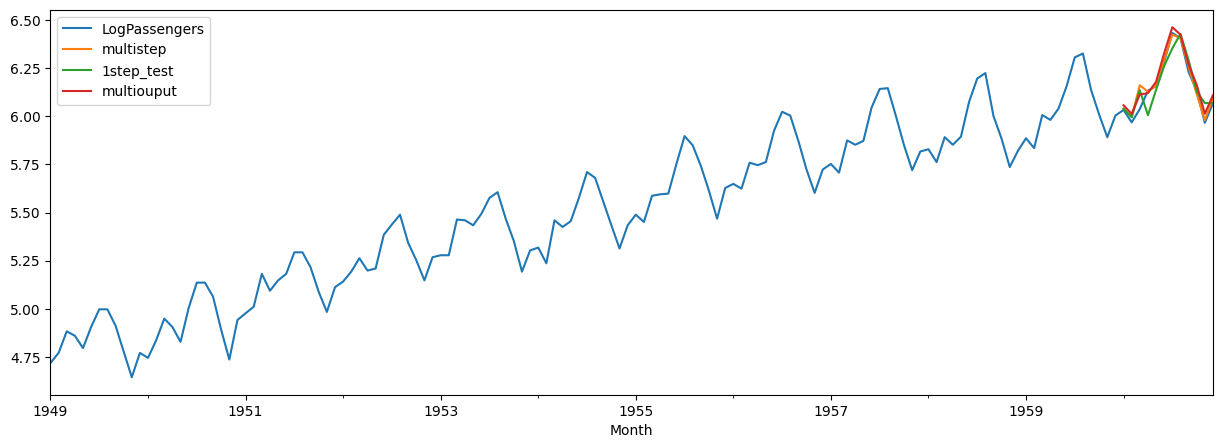

In [36]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

# AR like X values arel ike [y1 y2 y3] , [y2, y3, y4], so take the first col only
Ptrain = Ptrain[:,0] 
Ptest = Ptest[0]

# Store diff predictions
df.loc[test_idx, 'multiouput'] = last_train + np.cumsum(Ptest)

# Plot the result
cols = ['LogPassengers',
        'multistep', 
        '1step_test',
       'multiouput']
df[cols].plot(figsize = (15,5))


In [39]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multistep: ", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multiouput'])
print("multioutput: ", mape2)

multistep:  0.0037539337396450567
multioutput:  0.005845465798826863
